# In questo documento andiamo a selezionare le feature singolarmente da ogni documento

In [1]:
# Importiamo le librerie

from os import listdir
from os.path import isfile, join
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import pickle

In [2]:
# Variabili globali

mypath = 'dataset'

# Mi vado a prendere i path di tutti i file nella cartella dataset

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
onlyfiles

['Friday-02-03-2018_TrafficForML_CICFlowMeter.csv',
 'Friday-16-02-2018_TrafficForML_CICFlowMeter.csv',
 'Friday-23-02-2018_TrafficForML_CICFlowMeter.csv',
 'Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv',
 'Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv',
 'Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv',
 'Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv',
 'Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv',
 'Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv',
 'Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv']

In [4]:


# Indice per il file corrente da analizzare 

current = 0

# Questi campi non sono di interesse, quindi li escludiamo dalle analisi

first = []

if current == 3:
    first = ['Dst Port', 'Protocol', 'Timestamp','Flow ID','Src IP','Dst IP']
else:
    first = ['Dst Port', 'Protocol', 'Timestamp']


In [5]:
# Mi creo una cartella image all'interno del quale per ogni file vado a inserire le immagini d'interesse

if not os.path.exists("image"):
    os.makedirs("image")
    for a in onlyfiles:
        b = a.replace('.csv','')
        os.makedirs("image/"+b)
        os.makedirs("image/"+b+"/scatter")
        os.makedirs("image/"+b+"/istogrammi")

# Se non esiste, creo una cartella dove salvare le migliori feature

if not os.path.exists("top_feature"):
    os.makedirs("top_feature")
    for a in onlyfiles:
        b = a.replace('.csv','')
        os.makedirs("top_feature/"+b)

if not os.path.exists("pickle"):
    os.makedirs("pickle")
    for a in onlyfiles:
        b = a.replace('.csv','')
        os.makedirs("pickle/"+b)

# Per ogni documento andiamo a eseguire le operazioni di pre-processing, e a selezionare le feature d'interesse

In [6]:
document= pd.read_csv(mypath+'/'+onlyfiles[current])
scarto = []
scarto.append([])
folder = onlyfiles[current].replace('.csv','')
attaccanti_label = document['Label'].unique()[document['Label'].unique() != 'Label']

In [7]:
# Andiamo a eliminare i primi 3 campi inutili

for a in first:
    document.drop(columns=a,axis=1,inplace=True)

In [8]:
# Eliminiamo tutte le feature che hanno un solo valore

for a in document.head(0):
    
    if(document[a].unique().shape[0] == 1):
        scarto[-1].append(a)
        document.drop(columns=a,axis=1,inplace=True)
    else:
        continue

In [9]:
# Creo un duplicato solo per il plot 

document_plot = document

In [10]:
#rimuovo tutte le righe che sono una duplicazione dell'intestazione
document = document[document.Label != "Label"]
document_plot = document_plot[document_plot.Label != "Label"]

In [11]:
print(document.shape)

(1048575, 67)


In [12]:
# Andiamo a sostituire le label con valori interi

for b,c in zip(attaccanti_label,range(len(attaccanti_label))):
    document = document.replace(b, c)

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 100)
display(document)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.000000,655.432936,30597.305230,113.166178,9.425667e+03,1.906912e+04,73403.0,1.0,141385.0,1.767312e+04,2.396532e+04,73403.0,22.0,51417.0,8.569500e+03,1.303689e+04,31525.0,1.0,0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,1,0,270.375000,61.444444,539.000000,9,553,7,3773,8192,119,4,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
1,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.000000,0.000000,135231.316700,10676.156580,1.405000e+02,1.746554e+02,264.0,17.0,281.0,2.810000e+02,0.000000e+00,281.0,281.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,25.333333,19.000000,0.000000,2,38,1,0,123,0,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
2,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.800000,636.314186,41501.086400,92.915547,1.119296e+04,2.437945e+04,112589.0,1.0,279728.0,2.797280e+04,3.616774e+04,112589.0,94.0,258924.0,1.849457e+04,3.635650e+04,133669.0,1.0,0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,1,1,446.653846,98.727273,701.800000,11,1086,15,10527,8192,1047,5,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
3,132,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,15151.515150,1.320000e+02,0.000000e+00,132.0,132.0,132.0,1.320000e+02,0.000000e+00,132.0,132.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,15151.515150,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,256,-1,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
4,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,0,472.384615,611.180489,27100.607260,80.287282,1.304838e+04,2.631163e+04,114077.0,1.0,273946.0,3.424325e+04,3.799657e+04,114077.0,201.0,252994.0,2.108283e+04,3.907574e+04,135611.0,1.0,0,192,272,32.844797,47.442485,0,1460,322.869565,497.254764,247262.300400,0,0,1,1,0,0,1,1,337.545455,142.777778,472.384615,9,1285,13,6141,8192,1047,5,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
5,250,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,8000.000000,2.500000e+02,0.000000e+00,250.0,250.0,250.0,2.500000e+02,0.000000e+00,250.0,250.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,8000.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,251,-1,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
6,5964033,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.670687,1.988011e+06,3.425210e+06,5943084.0,19.0,5964033.0,2.982016e+06,4.187582e+06,5943084.0,20949.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,72,32,0.503015,0.167672,0,0,0.000000,0.000000,0.000000,0,0,1,1,0,0,1,0,0.000000,0.000000,0.000000,3,0,1,0,8192,29200,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
7,144,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,13888.888890,1.440000e+02,0.0

In [14]:
# Nel documento sono presenti valori infiniti, li andiamo a sostituire con Nan che verranno successivamente rimossi

document.replace([np.inf, -np.inf], np.nan, inplace=True)
document_plot.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
display(document)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.000000,655.432936,30597.305230,113.166178,9.425667e+03,1.906912e+04,73403.0,1.0,141385.0,1.767312e+04,2.396532e+04,73403.0,22.0,51417.0,8.569500e+03,1.303689e+04,31525.0,1.0,0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,1,0,270.375000,61.444444,539.000000,9,553,7,3773,8192,119,4,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
1,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.000000,0.000000,135231.316700,10676.156580,1.405000e+02,1.746554e+02,264.0,17.0,281.0,2.810000e+02,0.000000e+00,281.0,281.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,25.333333,19.000000,0.000000,2,38,1,0,123,0,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
2,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.800000,636.314186,41501.086400,92.915547,1.119296e+04,2.437945e+04,112589.0,1.0,279728.0,2.797280e+04,3.616774e+04,112589.0,94.0,258924.0,1.849457e+04,3.635650e+04,133669.0,1.0,0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,1,1,446.653846,98.727273,701.800000,11,1086,15,10527,8192,1047,5,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
3,132,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,15151.515150,1.320000e+02,0.000000e+00,132.0,132.0,132.0,1.320000e+02,0.000000e+00,132.0,132.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,15151.515150,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,256,-1,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
4,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,0,472.384615,611.180489,27100.607260,80.287282,1.304838e+04,2.631163e+04,114077.0,1.0,273946.0,3.424325e+04,3.799657e+04,114077.0,201.0,252994.0,2.108283e+04,3.907574e+04,135611.0,1.0,0,192,272,32.844797,47.442485,0,1460,322.869565,497.254764,247262.300400,0,0,1,1,0,0,1,1,337.545455,142.777778,472.384615,9,1285,13,6141,8192,1047,5,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
5,250,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,8000.000000,2.500000e+02,0.000000e+00,250.0,250.0,250.0,2.500000e+02,0.000000e+00,250.0,250.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,8000.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,251,-1,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
6,5964033,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.670687,1.988011e+06,3.425210e+06,5943084.0,19.0,5964033.0,2.982016e+06,4.187582e+06,5943084.0,20949.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,72,32,0.503015,0.167672,0,0,0.000000,0.000000,0.000000,0,0,1,1,0,0,1,0,0.000000,0.000000,0.000000,3,0,1,0,8192,29200,0,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0
7,144,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,13888.888890,1.440000e+02,0.0

In [16]:
# Eliminiamo i valori nulli

document.dropna(inplace=True)
document_plot.dropna(inplace=True)

In [17]:
df1 = document[document.isna().any(axis=1)]
display(df1)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


In [18]:
# Andiamo a castare tutte le stringhe rimanenti in numeri, in quanto alcuni numeri sono rappresentati come stringhe

for label in document_plot.head(0):
    if(label != 'Label'):
        try:
            document[label] = document[label].astype(float)
            document_plot[label] = document_plot[label].astype(float)
        except:
            print(label)

In [19]:
document.replace([np.inf, -np.inf], np.nan, inplace=True)
document_plot.replace([np.inf, -np.inf], np.nan, inplace=True)

In [20]:
df1 = document[document.isna().any(axis=1)]
display(df1)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


In [21]:
document.dropna(inplace=True)
document_plot.dropna(inplace=True)

In [22]:
print(document.shape)

(1044525, 67)


In [23]:
# Definisco una funzione per normalizzare i valori

def normalize(feature:str):
    return (document[feature]-document[feature].min())/(document[feature].max()-document[feature].min())

def normalize_plot(feature:str):
    return (document_plot[feature]-document_plot[feature].min())/(document_plot[feature].max()-document_plot[feature].min())


# Andiamo a normalizzare i valori per poter usare i vari algoritmi di feature selection

scaled_document = document.head(0)
scaled_document_plot = document_plot.head(0)

for a in document.head(0):
    
    try:
        if document[a].max() != 0 and a != 'Label':
            scaled_document[a] = normalize(a)
            scaled_document_plot[a] = normalize_plot(a)
        else:
            scaled_document[a] = document[a]
            scaled_document_plot[a] = document_plot[a]
    except:

        print(a)
        
        

In [24]:
display(scaled_document)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.178200e-03,0.000185,0.000101,0.000502,3.735644e-05,0.118060,0.000000,0.042085,0.084789,1.000000,0.000000,0.369274,0.634878,6.374439e-05,3.771650e-05,7.854306e-05,2.256700e-04,6.116833e-04,8.333333e-09,1.178208e-03,1.472760e-04,2.829436e-04,6.116917e-04,1.833333e-07,4.284750e-04,7.141250e-05,1.537369e-04,2.627083e-04,8.333333e-09,0.0,0.000084,0.000110,2.121580e-05,2.475510e-05,0.000000,0.853302,0.174981,0.563169,3.171595e-01,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.160222,0.042085,0.369274,0.000185,0.000502,0.000101,3.735656e-05,0.125015,0.001831,0.000432,0.454545,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0
1,2.333333e-06,0.000023,0.000014,0.000035,0.000000e+00,0.022209,0.000000,0.013014,0.026027,0.000000,0.000000,0.000000,0.000000,2.817319e-04,3.558713e-03,1.166667e-06,2.066928e-06,2.191667e-06,1.416667e-07,2.341667e-06,2.341667e-06,0.000000e+00,2.341667e-06,2.341667e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000018,0.000014,2.372476e-03,1.779359e-03,0.000000,0.022209,0.013065,0.026027,6.774254e-04,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.015012,0.013014,0.000000,0.000023,0.000035,0.000014,0.000000e+00,0.001892,0.000015,0.000000,0.454545,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0
2,2.331858e-03,0.000232,0.000217,0.000987,1.042277e-04,0.225015,0.000000,0.067621,0.125335,1.000000,0.000000,0.480810,0.616359,8.646060e-05,3.096629e-05,9.327050e-05,2.885142e-04,9.382333e-04,8.333333e-09,2.331067e-03,2.331067e-04,4.270099e-04,9.382417e-04,7.833333e-07,2.157700e-03,1.541214e-04,4.287324e-04,1.113908e-03,8.333333e-09,0.0,0.000102,0.000225,1.310062e-05,2.680256e-05,0.000000,0.853302,0.295756,0.671744,4.512402e-01,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.006757,0.264684,0.067621,0.480810,0.000232,0.000987,0.000217,1.042281e-04,0.125015,0.015991,0.000540,0.454545,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0
3,1.091667e-06,0.000023,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,5.050500e-03,1.095833e-06,0.000000e+00,1.091667e-06,1.100000e-06,1.100000e-06,1.100000e-06,0.000000e+00,1.100000e-06,1.100000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000018,0.000000,5.050502e-03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.000000e+00,0.003922,0.000000,0.000000,0.454545,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0
4,2.283458e-03,0.000185,0.000188,0.001168,6.080198e-05,0.302162,0.000000,0.097793,0.178121,1.000000,0.000000,0.323635,0.592014,5.645960e-05,2.675687e-05,1.087323e-04,3.113802e-04,9.506333e-04,8.333333e-09,2.282883e-03,2.853604e-04,4.486017e-04,9.506417e-04,1.675000e-06,2.108283e-03,1.756903e-04,4.607988e-04,1.130092e-03,8.333333e-09,0.0,0.000084,0.000196,1.094541e-05,2.372124e-05,0.000000,0.853302,0.222014,0.589911,3.479954e-01,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.006757,0.20002

In [25]:
df1 = scaled_document[scaled_document.isna().any(axis=1)]
display(df1)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


In [26]:
# A questo punto andiamo a salvare gli istogrammi delle varie feature per effettuare analisi visive

for h in scaled_document.head(0):

    # Stampo un istogramma per ogni valori di label, così da avere la suddivisione per colore
    
    for b,c in zip(attaccanti_label,range(len(attaccanti_label))):
        scaled_document[scaled_document['Label'] == c][h].hist(label=str(b))
        
    plt.legend()
    plt.title(h)
    feature_name = h.replace('/','_')
    plt.savefig('image/'+folder+'/'+'istogrammi/'+str(feature_name)+'.png')
    plt.close()

In [27]:
# Vado a suddividere il dataset in x e y per applicare successivamente, i vari algoritmi di feature selection

x_selection = scaled_document.iloc[:,:-1]
y_selection = scaled_document.iloc[:,-1:]

In [28]:
print(y_selection.shape)
print(x_selection.isna().sum().sum())

(1044525, 1)
0


In [29]:

# Applico il test Anova sul dataset

fvalue_Best = SelectKBest(score_func=f_classif, k=10)
fit = fvalue_Best.fit(x_selection, y_selection.astype('int'))

C:\Users\chiar\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
# Andiamo a stampare le migliori dieci feature selezionate da Anova su un file csv

features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(x_selection.columns)
feature_score = pd.concat([features,features_score],axis=1)

# Assegniamo un nuovo nome alle colonne

feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(10,columns="F_Score"))

       Input_Features        F_Score
9     Bwd Pkt Len Max  148261.227351
41       RST Flag Cnt  124144.692968
45       ECE Flag Cnt  124143.237759
11   Bwd Pkt Len Mean  115096.496256
49   Bwd Seg Size Avg  115096.496256
12    Bwd Pkt Len Std  107053.367531
57   Fwd Seg Size Min  103793.429739
55  Init Bwd Win Byts   94918.642107
47       Pkt Size Avg   91673.144015
35        Pkt Len Max   83222.868204


In [31]:
# Mi vado a salvare le migliori 10 feature ottenute dal test Anova con il relativo punteggio

feature_score.nlargest(10,columns="F_Score").to_csv('top_feature/'+folder+'/anova.csv',index=False)

In [32]:
print(x_selection.head(0),y_selection.head(0))

Empty DataFrame
Columns: [Flow Duration, Tot Fwd Pkts, Tot Bwd Pkts, TotLen Fwd Pkts, TotLen Bwd Pkts, Fwd Pkt Len Max, Fwd Pkt Len Min, Fwd Pkt Len Mean, Fwd Pkt Len Std, Bwd Pkt Len Max, Bwd Pkt Len Min, Bwd Pkt Len Mean, Bwd Pkt Len Std, Flow Byts/s, Flow Pkts/s, Flow IAT Mean, Flow IAT Std, Flow IAT Max, Flow IAT Min, Fwd IAT Tot, Fwd IAT Mean, Fwd IAT Std, Fwd IAT Max, Fwd IAT Min, Bwd IAT Tot, Bwd IAT Mean, Bwd IAT Std, Bwd IAT Max, Bwd IAT Min, Fwd PSH Flags, Fwd Header Len, Bwd Header Len, Fwd Pkts/s, Bwd Pkts/s, Pkt Len Min, Pkt Len Max, Pkt Len Mean, Pkt Len Std, Pkt Len Var, FIN Flag Cnt, SYN Flag Cnt, RST Flag Cnt, PSH Flag Cnt, ACK Flag Cnt, URG Flag Cnt, ECE Flag Cnt, Down/Up Ratio, Pkt Size Avg, Fwd Seg Size Avg, Bwd Seg Size Avg, Subflow Fwd Pkts, Subflow Fwd Byts, Subflow Bwd Pkts, Subflow Bwd Byts, Init Fwd Win Byts, Init Bwd Win Byts, Fwd Act Data Pkts, Fwd Seg Size Min, Active Mean, Active Std, Active Max, Active Min, Idle Mean, Idle Std, Idle Max, Idle Min]
Index: 

In [33]:
# Utilizziamo altri metodi di feature extraction per prendere le migliori 10 feature

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_selection, y_selection.astype('int'))

C:\Users\chiar\AppData\Local\Temp\ipykernel_18320\4268670838.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(x_selection, y_selection.astype('int'))


In [34]:
features_score = pd.DataFrame(clf.feature_importances_)
features = pd.DataFrame(x_selection.columns)
feature_score = pd.concat([features,features_score],axis=1)

# Assegniamo un nuovo nome alle colonne

feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(15,columns="F_Score"))

       Input_Features   F_Score
41       RST Flag Cnt  0.111867
45       ECE Flag Cnt  0.087569
43       ACK Flag Cnt  0.066190
54  Init Fwd Win Byts  0.054469
32         Fwd Pkts/s  0.048728
14        Flow Pkts/s  0.046727
35        Pkt Len Max  0.041119
9     Bwd Pkt Len Max  0.038086
18       Flow IAT Min  0.029205
23        Fwd IAT Min  0.028785
5     Fwd Pkt Len Max  0.028203
49   Bwd Seg Size Avg  0.026626
44       URG Flag Cnt  0.023299
11   Bwd Pkt Len Mean  0.023038
37        Pkt Len Std  0.022821


In [35]:
# Mi vado a salvare le migliori 10 feature ottenute dal test Anova con il relativo punteggio

feature_score.nlargest(10,columns="F_Score").to_csv('top_feature/'+folder+'/ExtraTree.csv',index=False)

In [36]:
# Utilizziamo SVM come metodo di feature selection

features_names = x_selection.head(0)
svm = svm.SVC(kernel='linear',max_iter=400)
svm.fit(x_selection, y_selection.astype('int'))

C:\Users\chiar\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chiar\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=400)

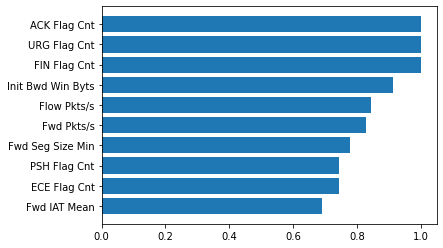

In [37]:
# Questa è una funziona che mi permette di visualizzare le migliori feature

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names[-10:])), imp[-10:], align='center')
    plt.yticks(range(len(names[-10:])), names[-10:])
    plt.show()


f_importances(abs(svm.coef_[0]), features_names)

In [38]:
top_svm = pd.DataFrame()

for a in sorted(zip(abs(svm.coef_[0]),features_names),reverse=True):
    top_svm = pd.concat([top_svm, pd.DataFrame([a])], ignore_index=True)

top_svm.rename(columns = {0:'F_Score', 1:'Input_Features'}, inplace = True)
print(top_svm.head(10))

top_svm.nlargest(10,columns="F_Score").to_csv('top_feature/'+folder+'/SVM.csv',index=False)

    F_Score     Input_Features
0  1.000000       ACK Flag Cnt
1  1.000000       URG Flag Cnt
2  1.000000       FIN Flag Cnt
3  0.914249  Init Bwd Win Byts
4  0.843071        Flow Pkts/s
5  0.827847         Fwd Pkts/s
6  0.779798   Fwd Seg Size Min
7  0.744979       PSH Flag Cnt
8  0.744979       ECE Flag Cnt
9  0.692241       Fwd IAT Mean


In [39]:
# Ultimo metodo di feature selection che utilizziamo è quello RFE, che sta per Recorsive Feature Elimination

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(x_selection, y_selection.astype('int'))

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

In [40]:
# Andiamo a salvare le feature in un file csv

features_score = pd.DataFrame(rfe.ranking_)
features = pd.DataFrame(x_selection.columns)
feature_score = pd.concat([features,features_score],axis=1)

feature_score.columns = ["Input_Features","F_Score"]
feature_score.sort_values('F_Score',inplace=True,ascending=False,axis=0)
feature_score.nsmallest(10,columns="F_Score").to_csv('top_feature/'+folder+'/RFE.csv',index=False)

In [41]:
# Per non creare un solo file troppo ricco di codice salviamo i dataset in formato pickle 
# per utilizzarlo successivamente in un altro file

with open('pickle/'+folder+'/scaled_document.pickle', 'wb') as handle:
    pickle.dump(scaled_document, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
with open('pickle/'+folder+'/scaled_document_plot.pickle', 'wb') as handle:
    pickle.dump(scaled_document_plot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()